In [66]:
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from torch.utils.data.dataloader import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from ssapp.Utils import FigureSaver
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver(subfolder='Latent Space Plots')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:

dataset_names = ['ReflectorCutDataset2','PatchAntennaDataset2','CircularHornDataset1','MLADataset1']

NUM_PCA = 20

train_loss_list =[]
val_loss_list = []
var_explained_list = []

for idx,dataset_name in enumerate(dataset_names):

    train_dataset = load_serialized_dataset(dataset_name+'_Train')
    val_dataset = load_serialized_dataset(dataset_name+'_Val')

    train_samples = len(train_dataset)
    val_samples = len(val_dataset)

    train_params,train_fields = next(iter(DataLoader(train_dataset,batch_size=train_samples)))
    val_params,val_fields = next(iter(DataLoader(val_dataset,batch_size=val_samples)))



    # Make PCA on fields

    train_loss = np.array([])
    val_loss = np.array([])

    pca = PCA(n_components=NUM_PCA)

    train_latent = pca.fit_transform(train_fields.reshape(train_samples,-1))
    val_latent = pca.transform(val_fields.reshape(val_samples,-1))

    var_explained_list.append(pca.explained_variance_ratio_)
    # Loop over all PCA components
    for i in range(1,NUM_PCA):
        # In reverse order, set the PCA components to 0
        train_latent[:,-i] = np.zeros_like(train_latent[:,-i])
        val_latent[:,-i] = np.zeros_like(val_latent[:,-i])
        # Reconstruct the fields using the N-i PCA components
        train_reconstruction = pca.inverse_transform(train_latent)
        val_reconstruction = pca.inverse_transform(val_latent)
        # Calculate the reconstruction loss with both inputs flattened
        pca_train_loss = relRMSE(train_fields.reshape(train_samples,-1),train_reconstruction.reshape(train_samples,-1))
        pca_val_loss = relRMSE(val_fields.reshape(val_samples,-1),val_reconstruction.reshape(val_samples,-1))
        # Append the reconstruction loss to the list
        train_loss = np.append(train_loss,pca_train_loss)
        val_loss = np.append(val_loss,pca_val_loss)
    
    # Print train loos
    print('Train loss for dataset {}: {}'.format(dataset_name,train_loss))
    # Print val loss
    print('Val loss for dataset {}: {}'.format(dataset_name,val_loss))

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)


train_loss_list = np.flip(np.array(train_loss_list).T,axis = 0)
val_loss_list = np.flip(np.array(val_loss_list).T,axis = 0)





Train loss for dataset ReflectorCutDataset2: [0.00873865 0.00883668 0.00893948 0.00905378 0.00918135 0.00931268
 0.00944967 0.00961945 0.00982496 0.01007199 0.01036999 0.01075544
 0.01124903 0.01202484 0.01536736 0.02080303 0.0367254  0.0545776
 0.83215509]
Val loss for dataset ReflectorCutDataset2: [0.00918171 0.00922384 0.00926986 0.00934298 0.00942362 0.00949049
 0.00954747 0.00973967 0.00987206 0.01009992 0.01032509 0.01064221
 0.01111153 0.0118441  0.01756353 0.02156173 0.04177612 0.05412936
 0.90935382]
Train loss for dataset PatchAntennaDataset2: [1.20228945e-05 1.41414632e-05 1.64133087e-05 1.98836136e-05
 2.30364307e-05 2.90505699e-05 3.94541847e-05 4.93312939e-05
 6.73110974e-05 1.22650632e-04 1.66505810e-04 3.23760029e-04
 4.59406863e-04 7.92113458e-04 1.22563815e-03 5.38730873e-03
 3.68783822e-02 6.00098364e-02 1.90753873e-01]
Val loss for dataset PatchAntennaDataset2: [1.19685113e-05 1.41625679e-05 1.61726313e-05 1.96754342e-05
 2.26914865e-05 2.85524484e-05 3.94449959e-05

In [68]:
for dataset_name in dataset_names:
    print(len(load_serialized_dataset(dataset_name)))

360
3374
4000
10000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


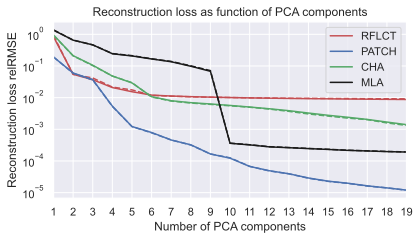

In [67]:

from ssapp.visualization.PCA_Visualisation import plotAllDatasetPCAReconstructionLoss

# list with label names
label_names = ['RFLCT','PATCH','CHA','MLA']

## Plot reconstruction loss
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()




fig,ax = plt.subplots(1,1,figsize=(6,3.5),dpi=300,tight_layout=True)
for idx,c in enumerate(['r','b','g','k']):
    ax.semilogy([x for x in range(1,NUM_PCA)],train_loss_list[:,idx],label=label_names[idx], color = c)
    ax.semilogy([x for x in range(1,NUM_PCA)],val_loss_list[:,idx],linestyle='--',color = c)
ax.set_xticks(list(range(1,NUM_PCA)))
ax.set_xlabel('Number of PCA components')
ax.set_ylabel('Reconstruction loss relRMSE')
ax.set_xlim(1,NUM_PCA-1)
ax.legend()
ax.set_title('Reconstruction loss as function of PCA components')

figSaver(filename='PCAReconstructionLossAllDatasets')